In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pickle

import proplot as pplt
from graph_utils import *
from data_utils import *
from model_utils import *
from analysis_utils import *
from saliency_utils import *
from generation_utils import *

DATA_DIR = '/scratch/gpfs/sj0161/topo_data/'
WEIGHT_DIR = '/scratch/gpfs/sj0161/topo_result/'
ANALYSIS_DIR = '/scratch/gpfs/sj0161/topo_analysis/'


pplt.rc['figure.facecolor'] = 'white'

COLORS = []
colors1 = pplt.Cycle('default')
colors2 = pplt.Cycle('538')

for color in colors1:
    COLORS.append(color['color'])

for color in colors2:
    COLORS.append(color['color'])

LATENT_DIM = 8

In [4]:
# Load latent space
with open(os.path.join(ANALYSIS_DIR, "latent_space.pickle"), "rb") as handle:
    latent_train = pickle.load(handle)
    latent_valid = pickle.load(handle)
    latent_test = pickle.load(handle)
    
latent_all = np.concatenate((latent_train, latent_valid, latent_test), axis=0)

# Load data label
((x_train, y_train, c_train, l_train, graph_train),
(x_valid, y_valid, c_valid, l_valid, graph_valid),
(x_test, y_test, c_test, l_test, graph_test),
NAMES, SCALER, LE) = load_data(os.path.join(DATA_DIR, 'rg2.pickle'), fold=0, if_validation=True)

graph_all = np.concatenate((graph_train, graph_valid, graph_test))
y_all = np.concatenate((y_train, y_valid, y_test))
c_all = np.concatenate((c_train, c_valid, c_test))

# Load TopoGNN model
file = "desc_gnn_cnn_20230828_8_val_decoder_acc_True_True_1.0_[1.0, 1, 1]_0.001_64"

ENCODER, DECODER, MONITOR, IF_REG, IF_CLS, weights, LR, BS = get_spec(file)

model, pickle_file = train_vae(ENCODER, DECODER, MONITOR, IF_REG, IF_CLS,
                               x_train, x_valid, y_train, y_valid, c_train, c_valid,
                               l_train, l_valid, 1.0, weights, LR, BS, False)

desc_gnn_cnn_20230828_8_val_decoder_acc_True_True_1.0_[1.0, 1, 1]_0.001_64.h5 finished in 1.05 sec ...


In [ ]:
def check_isomorphism(graph_list, new_graph):
    for graph in graph_list:
        if nx.is_isomorphic(graph, new_graph):
            return True
    return False


def rg_latent_vector(l, y_train, c_train, poly_type='branch', target_rg=40):
    
    idx = np.where(NAMES == poly_type)[0][0]

    a = l[np.where(c_train == idx)[0]]
    y = y_train[np.where(c_train == idx)[0]]
    
    if np.abs(y - target_rg).min() < 1:
        
        idx2 = np.where(np.abs(y - target_rg) < 1)[0]

        return a[idx2], y[idx2]
    
    else:
        
        return None, None

In [19]:
def gen_prop_polymer(target_rg=30, target_top="branch", max_iter=1000):
    outputs = []
    graphs = []
    

    latent_vector, rg_dataset = rg_latent_vector(latent_all, y_all, c_all, target_top, target_rg)
    
    if latent_vector is None:
        raise Exception("The target rg2 is too large/small ")

    for i in range(max_iter):
        noise = np.random.normal(0, 1, (1, 8)) * 0.1
        
        num = len(latent_vector)

        for j in range(num):
            K.clear_session()
            d_in = latent_vector[j, ...] + noise
            graph_raw, graph, gen_cls, cln_cls, gen_reg, cln_reg_m, cln_reg_s = polymer_generation(model, d_in, None, ENCODER)

            flag1 = np.abs(gen_reg - cln_reg_m) < 2
            flag2 = np.abs(gen_reg - target_rg) < 2
            flag3 = np.abs(cln_reg_m - target_rg) < 2
            flag4 = gen_cls == cln_cls
            flag5 = cln_cls == target_top

            x_clean_ = nx.to_numpy_array(graph)
            n_clean = len(x_clean_)
            x_clean = np.zeros((1, 100, 100))
            x_clean[0, :n_clean, :n_clean] = x_clean_
            x_clean = x_clean.astype("int")

            l_clean = get_desc(graph)[None, ...]
            l_clean = SCALER.transform(l_clean)

            d_clean = latent_model(model, data=[x_clean, l_clean], enc_type=ENCODER, mean_var=False)

            if flag1 and flag2 and flag3 and flag4 and flag5: 
                if len(graphs) > 0:
                    if not check_isomorphism(graphs, graph) and not check_isomorphism(graph_all, graph):
                        graphs.append(graph)
                        outputs.append([d_in, graph_raw, graph, gen_cls, cln_cls, gen_reg, cln_reg_m, cln_reg_s, latent_vector[j, ...], d_in, d_clean])
                else:
                    graphs.append(graph)
                    outputs.append([d_in, graph_raw, graph, gen_cls, cln_cls, gen_reg, cln_reg_m, cln_reg_s, latent_vector[j, ...], d_in, d_clean])

            print(f"{len(outputs)}/{num * max_iter} found ...", end="\r")
    # check latent space distance
    z_cleans = []
    z_raws   = []
    rmses    = []
    new_outputs = []
    
    for i in range(len(outputs)):
        graph = outputs[i][2]
        x_clean_ = nx.to_numpy_array(graph)
        n_clean = len(x_clean_)
        x_clean = np.zeros((1, 100, 100))
        x_clean[0, :n_clean, :n_clean] = x_clean_
        x_clean = x_clean.astype("int")

        l_clean = get_desc(graph)[None, ...]
        l_clean = SCALER.transform(l_clean)

        z_clean = latent_model(model, data=[x_clean, l_clean], enc_type=ENCODER, mean_var=False).squeeze()

        z_raw = outputs[i][0].squeeze()
        rmse = skm.mean_absolute_error(z_raw, z_clean)

        if rmse < 1:
            z_cleans.append(z_clean)
            z_raws.append(z_raw)
            rmses.append(rmse)
            new_outputs.append(outputs[i]+[z_clean])
            
    print(f"{len(new_outputs)}/{len(outputs)} latent space check passed ...")
            
    return new_outputs

In [27]:
target_rg  = 26.5
target_top  = "star"

outputs = gen_prop_polymer(target_rg=target_rg, target_top=target_top, max_iter=10)

3/3 latent space check passed ...


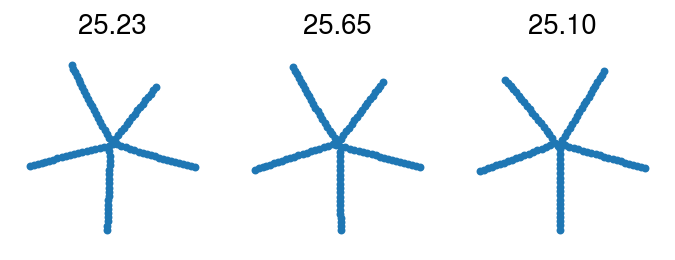

In [30]:
fig, ax = pplt.subplots(ncols=len(outputs), nrows=1, refwidth=1, refheight=1)

for i in range(len(outputs)):
    nx.draw(outputs[i][2], pos=nx.kamada_kawai_layout(outputs[i][2]), 
            node_size=5, ax=ax[i], node_color=COLORS[0])
    ax[i].set_title(f"{str(outputs[i][6])[:5]}")

In [32]:
target_rg  = 40
target_top  = "star"

outputs = gen_prop_polymer(target_rg=target_rg, target_top=target_top, max_iter=10)

6/6 latent space check passed ...


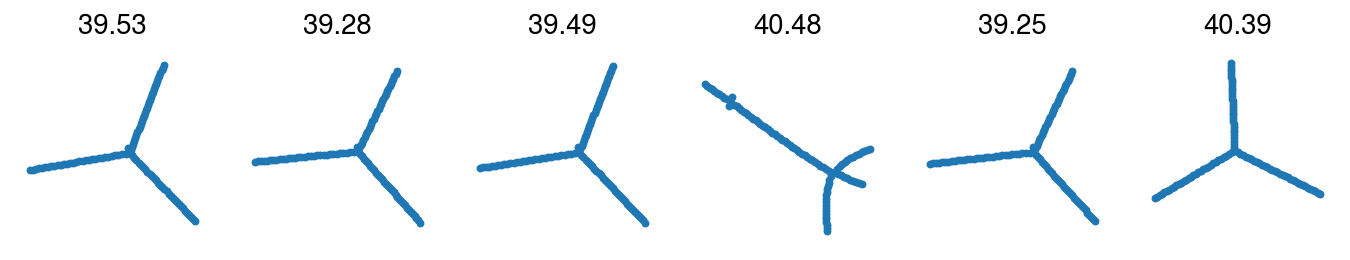

In [33]:
fig, ax = pplt.subplots(ncols=len(outputs), nrows=1, refwidth=1, refheight=1)

for i in range(len(outputs)):
    nx.draw(outputs[i][2], pos=nx.kamada_kawai_layout(outputs[i][2]), 
            node_size=5, ax=ax[i], node_color=COLORS[0])
    ax[i].set_title(f"{str(outputs[i][6])[:5]}")